In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress, pearsonr
import plotly.express as px

In [2]:

MLP_data_to_load = "Resources/Median_list_Price.csv"
MSP_data_to_load = "Resources/Median_sale_price.csv"


In [3]:
Median_list_price = pd.read_csv(MLP_data_to_load)
Median_Sale_price = pd.read_csv(MSP_data_to_load)



In [4]:
melted_data = pd.melt(Median_list_price, id_vars=['RegionID', 'SizeRank', 'RegionName','StateName'],
                      var_name='Date', value_name='MedianListPrice')

# Convert the 'Date' column to datetime format
melted_data['Date'] = pd.to_datetime(melted_data['Date'])

In [5]:
melted_data.isnull().sum()

RegionID             0
SizeRank             0
RegionName           0
StateName            0
Date                 0
MedianListPrice    364
dtype: int64

In [6]:
melted_data_cleaned = melted_data.dropna()

In [7]:
MLP = melted_data_cleaned.drop_duplicates()
MLP.head()

RegionID  SizeRank       RegionName StateName       Date  MedianListPrice
0    394913         1     New York, NY        NY 2018-03-31         503000.0
1    753899         2  Los Angeles, CA        CA 2018-03-31         721333.0
2    394463         3      Chicago, IL        IL 2018-03-31         284600.0
3    394514         4       Dallas, TX        TX 2018-03-31         322997.0
4    394692         5      Houston, TX        TX 2018-03-31         294467.0

In [8]:
row_count = len(MLP)
print("Number of rows:", row_count)

Number of rows: 45468


In [9]:
melt_data = pd.melt(Median_Sale_price, id_vars=['RegionID', 'SizeRank', 'RegionName','StateName'],
                      var_name='Date', value_name='MedianSalePrice')

# Convert the 'Date' column to datetime format
melt_data['Date'] = pd.to_datetime(melt_data['Date'])

In [10]:
melt_data.isnull().sum()

RegionID              0
SizeRank              0
RegionName            0
StateName             0
Date                  0
MedianSalePrice    3107
dtype: int64

In [11]:
melt_data_cleaned = melt_data.dropna()

In [12]:
MSP = melt_data_cleaned.drop_duplicates()
MSP.head()


RegionID  SizeRank       RegionName StateName       Date  MedianSalePrice
0    394913         1     New York, NY        NY 2018-03-31         376000.0
1    753899         2  Los Angeles, CA        CA 2018-03-31         608333.0
2    394463         3      Chicago, IL        IL 2018-03-31         222833.0
3    394514         4       Dallas, TX        TX 2018-03-31         244667.0
4    394692         5      Houston, TX        TX 2018-03-31         212417.0

In [13]:
house_prices = pd.merge(MLP, MSP, on=['RegionID', 'SizeRank', 'RegionName', 'StateName', 'Date'])

# Check the merged DataFrame
print(house_prices.head())

   RegionID  SizeRank       RegionName StateName       Date  MedianListPrice  \
0    394913         1     New York, NY        NY 2018-03-31         503000.0   
1    753899         2  Los Angeles, CA        CA 2018-03-31         721333.0   
2    394463         3      Chicago, IL        IL 2018-03-31         284600.0   
3    394514         4       Dallas, TX        TX 2018-03-31         322997.0   
4    394692         5      Houston, TX        TX 2018-03-31         294467.0   

   MedianSalePrice  
0         376000.0  
1         608333.0  
2         222833.0  
3         244667.0  
4         212417.0  


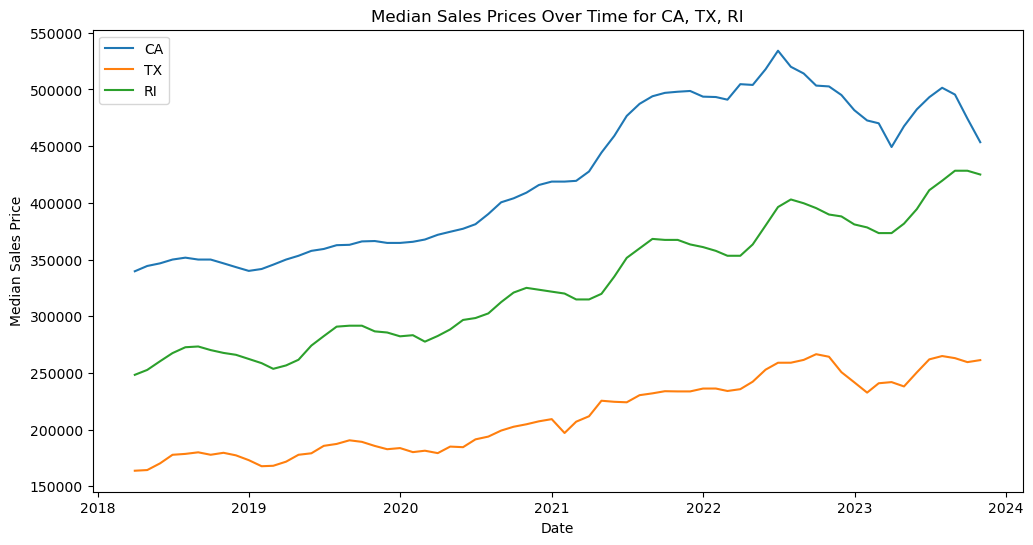

In [14]:
# Select 3 specific states
selected_states = ['CA', 'TX', 'RI']
df_selected = MSP[MSP['StateName'].isin(selected_states)]

# Group by 'State' and 'Date' and calculate the median sales price
grouped_data = df_selected.groupby(['StateName', 'Date'])['MedianSalePrice'].median().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

for state in selected_states:
    state_data = grouped_data[grouped_data['StateName'] == state]
    plt.plot(state_data['Date'], state_data['MedianSalePrice'], label=state)

plt.title('Median Sales Prices Over Time for CA, TX, RI')
plt.xlabel('Date')
plt.ylabel('Median Sales Price')
plt.legend()
plt.savefig('Median Sales Prices_plot.png')
plt.show()

In [15]:

df_merged = pd.merge(MLP, MSP, on=['RegionID', 'SizeRank', 'RegionName', 'StateName', 'Date'], how='inner')

# Drop rows with missing values in either MedianListPrice or MedianSalePrice
df_merged = df_merged.dropna(subset=['MedianListPrice', 'MedianSalePrice'])



In [16]:
# Convert the 'Date' column to datetime format
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Extract the year from the 'Date' column and create a new 'Year' column
df_merged['Year'] = df_merged['Date'].dt.year

# Group by 'Year' and 'StateName' and calculate the average of 'MedianListPrice' and 'MedianSalePrice'
df_avg = df_merged.groupby(['Year', 'StateName']).agg({
    'MedianListPrice': 'mean',
    'MedianSalePrice': 'mean'
}).reset_index()

# Calculate the price discrepancy
df_avg['PriceDiscrepancy'] =((df_avg['MedianSalePrice'] - df_avg['MedianListPrice']) / df_avg['MedianListPrice']) * 100
# Display the resulting dataframe
print(df_avg.head())

   Year StateName  MedianListPrice  MedianSalePrice  PriceDiscrepancy
0  2018        AL    196283.887500    148399.275000        -24.395590
1  2018        AR    172749.144444    132683.533333        -23.192943
2  2018        AZ    287947.377778    221899.422222        -22.937509
3  2018        CA    502202.254545    422267.281818        -15.916888
4  2018        CO    512141.861538    359952.123077        -29.716325


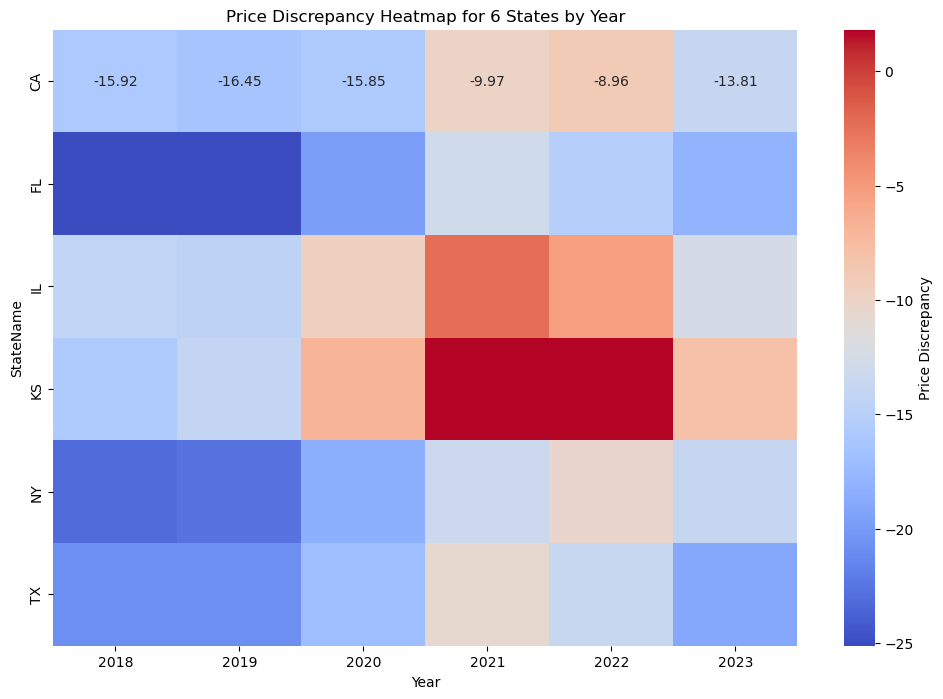

In [17]:
# 6 states of interest
states_of_interest = ['NY', 'CA', 'TX', 'FL', 'IL', 'KS']
df_states = df_avg[df_avg['StateName'].isin(states_of_interest)]

# Create a pivot table for the heatmap
pivot_table = df_states.pivot_table(values='PriceDiscrepancy', index='StateName', columns='Year')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Price Discrepancy'})
plt.title('Price Discrepancy Heatmap for 6 States by Year')
plt.savefig('Price Discrepancy_plot.png')
plt.show()

In [18]:
# Filter rows with positive price discrepancy
positive_discrepancy_df = df_avg[df_avg['PriceDiscrepancy'] > 0]

# Display the rows with positive price discrepancy
print(positive_discrepancy_df)

     Year StateName  MedianListPrice  MedianSalePrice  PriceDiscrepancy
158  2021        KS    186117.255319    189499.000000          1.816997
206  2022        KS    205783.104167    209430.666667          1.772528


/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

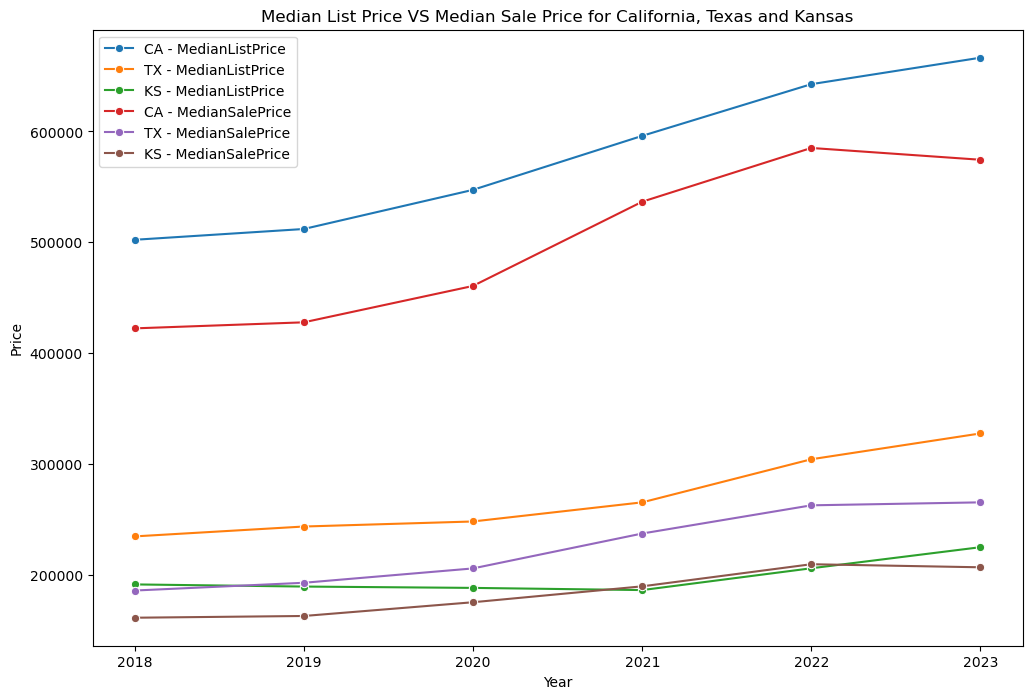

In [19]:

df_avg['Year'] = pd.to_datetime(df_avg['Year'], format='%Y')

# Filter the dataframe for specified states
states_of_interest = ['CA', 'TX','KS']
df_states = df_avg[df_avg['StateName'].isin(states_of_interest)]

# Pivot the dataframe for better plotting
pivot_table = df_states.pivot_table(values=['MedianListPrice', 'MedianSalePrice'], index=['Year'], columns='StateName')

# Plotting
plt.figure(figsize=(12, 8))

# Plot MedianListPrice for each state
for state in states_of_interest:
    sns.lineplot(data=pivot_table['MedianListPrice'][state], label=f'{state} - MedianListPrice', marker='o')

# Plot MedianSalePrice for each state
for state in states_of_interest:
    sns.lineplot(data=pivot_table['MedianSalePrice'][state], label=f'{state} - MedianSalePrice', marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Median List Price VS Median Sale Price for California, Texas and Kansas')
plt.legend()
plt.savefig('Median Sales Prices_plot.png')

# Display the plot
plt.show()

/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

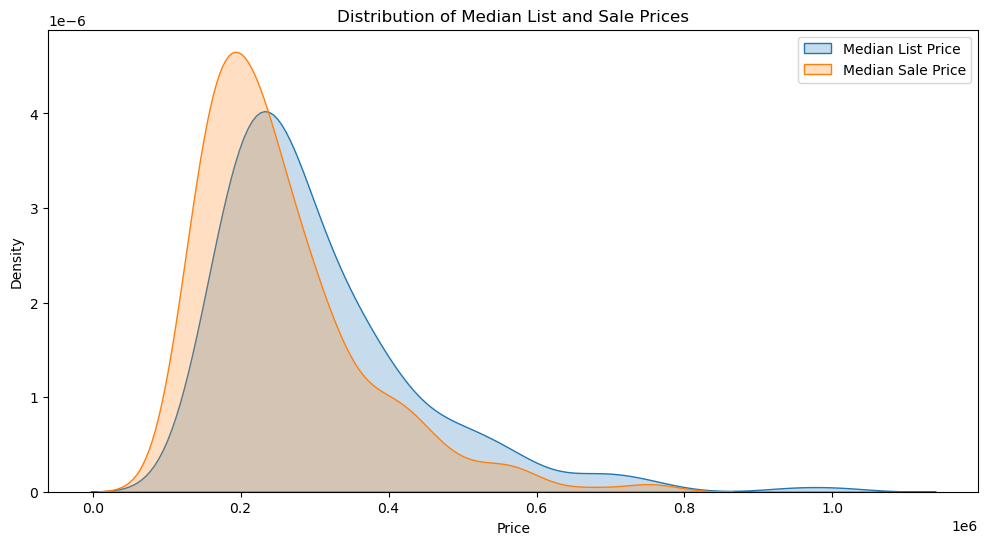

In [20]:
# Create kernel density plots for MedianListPrice and MedianSalePrice
plt.figure(figsize=(12, 6))

sns.kdeplot(df_avg['MedianListPrice'], label='Median List Price', fill=True)
sns.kdeplot(df_avg['MedianSalePrice'], label='Median Sale Price', fill=True)

# Set labels and title
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Median List and Sale Prices')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [21]:

# Compute summary statistics for Median List Price
list_price_mean = MLP['MedianListPrice'].mean()
list_price_std = MLP['MedianListPrice'].std()

# Compute summary statistics for Median Sale Price
sale_price_mean = MSP['MedianSalePrice'].mean()
sale_price_std = MSP['MedianSalePrice'].std()

# Display the summary statistics
print("Summary Statistics for Median List Price:")
print(f"Mean: {list_price_mean:.2f}")
print(f"Standard Deviation: {list_price_std:.2f}\n")

print("Summary Statistics for Median Sale Price:")
print(f"Mean: {sale_price_mean:.2f}")
print(f"Standard Deviation: {sale_price_std:.2f}")

Summary Statistics for Median List Price:
Mean: 278590.74
Standard Deviation: 174552.93

Summary Statistics for Median Sale Price:
Mean: 236321.50
Standard Deviation: 141586.75


In [22]:
import dask.dataframe as dd

# Convert pandas DataFrames to Dask DataFrames
dask_msp = dd.from_pandas(MSP, npartitions=10)  # Adjust npartitions as needed
dask_mlp = dd.from_pandas(MLP, npartitions=10)

# Perform the merge operation using Dask
dask_merged_data = dd.merge(dask_msp, dask_mlp, on='RegionName', how='inner')

# Convert the Dask DataFrame back to a pandas DataFrame
house_prices = dask_merged_data.compute()

/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


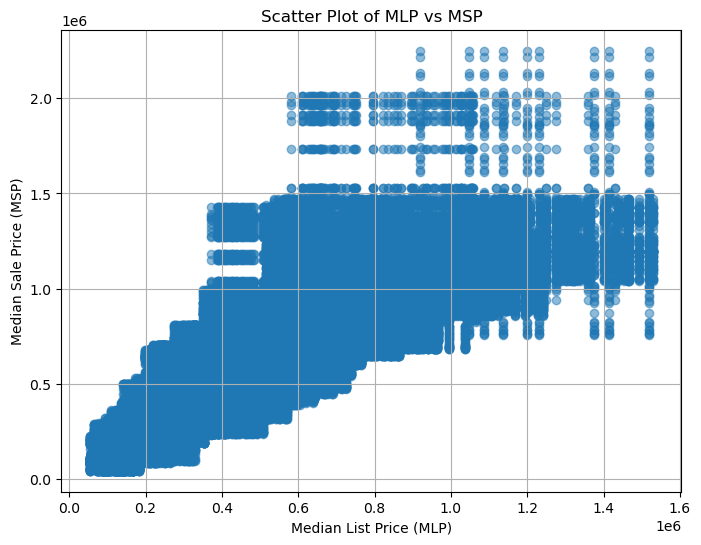

In [23]:
# Generate a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(house_prices['MedianSalePrice'], house_prices['MedianListPrice'], alpha=0.5)
plt.title('Scatter Plot of MLP vs MSP')
plt.xlabel('Median List Price (MLP)')
plt.ylabel('Median Sale Price (MSP)')
plt.savefig('Visualize the relationship_plot.png')
plt.grid(True)

Linear Regression: y = 0.72x + 31991.39
Correlation Coefficient: 0.88


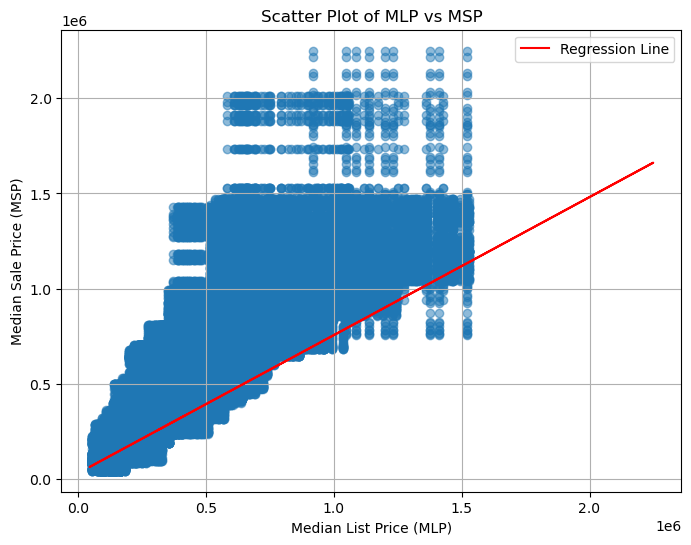

In [24]:
# Generate a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(house_prices['MedianSalePrice'], house_prices['MedianListPrice'], alpha=0.5)
plt.title('Scatter Plot of MLP vs MSP')
plt.xlabel('Median List Price (MLP)')
plt.ylabel('Median Sale Price (MSP)')
plt.grid(True)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(house_prices['MedianListPrice'], house_prices['MedianSalePrice'])

# Calculate correlation coefficient
correlation_coefficient, _ = pearsonr(house_prices['MedianListPrice'], house_prices['MedianSalePrice'])

# Print regression information

print(f"Linear Regression: y = {slope:.2f}x + {intercept:.2f}")
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")


# Plot the regression line
plt.plot(house_prices['MedianListPrice'], slope * house_prices['MedianListPrice'] + intercept, color='red', label='Regression Line')



# Show the plot
plt.legend()
plt.savefig('Scatter Plot of MLP vs MSP_plot.png')
plt.show()

/opt/homebrew/anaconda3/envs/bootcamp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


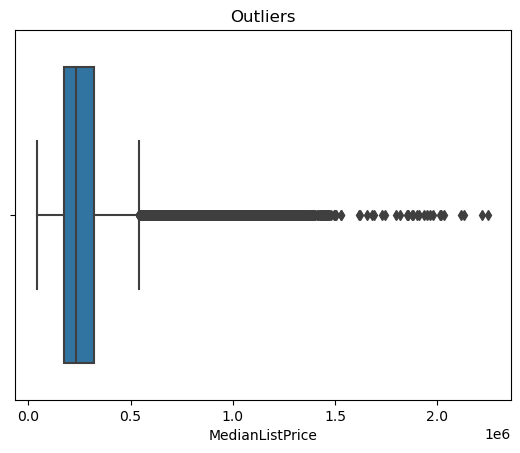

In [25]:
# Boxplot reflecting outliers
sns.boxplot(x=MLP['MedianListPrice'])
plt.title('Outliers')
plt.savefig('Boxplot Outliers_plot.png')

plt.show()

Box Plots:
Box plots visually represent the distribution of data and  identify outliers.Outliers are the points that fall beyond the "whiskers" of the box plot.

In [26]:
from scipy import stats

z_scores = stats.zscore(MLP['MedianListPrice'])
outliers = (z_scores > 3) | (z_scores < -3)
outlier_indices = MLP.index[outliers]

print(outlier_indices)

Index([   11,    34,   122,   123,   179,   427,   437,   448,   517,   643,
       ...
       45459, 45498, 45572, 45585, 45595, 45606, 45675, 45712, 45801, 45815],
      dtype='int64', length=1039)


In [27]:
Q1 = MLP['MedianListPrice'].quantile(0.25)
Q3 = MLP['MedianListPrice'].quantile(0.75)
IQR = Q3 - Q1

outliers = (MLP['MedianListPrice'] < Q1 - 1.5 * IQR) | (MLP['MedianListPrice'] > Q3 + 1.5 * IQR)
outlier_indices = MLP.index[outliers]

print("Indices of outliers:", outlier_indices)

Indices of outliers: Index([    1,    11,    16,    34,    53,    58,    69,   110,   122,   123,
       ...
       45709, 45712, 45723, 45746, 45766, 45787, 45791, 45801, 45815, 45830],
      dtype='int64', length=2960)


This indicates that there are 2960 rows (data points) identified as outliers, and the indices of these rows are given in the list. Each number in the list represents the row index in your original DataFrame where an outlier was detected.

In [28]:
outlier_indices = [    1,    11,    16,    34,    53,    58,    69,   110,   122,   123, 45709, 45712, 45723, 45746, 45766, 45787, 45791, 45801, 45815, 45830]
outliers_data = melted_data.iloc[outlier_indices]

print(outliers_data)

       RegionID  SizeRank                RegionName StateName       Date  \
1        753899         2           Los Angeles, CA        CA 2018-03-31   
11       395057        12         San Francisco, CA        CA 2018-03-31   
16       395056        17             San Diego, CA        CA 2018-03-31   
34       395059        36              San Jose, CA        CA 2018-03-31   
53       753924        55        Urban Honolulu, HI        HI 2018-03-31   
58       394415        60            Bridgeport, CT        CT 2018-03-31   
69       394952        71                Oxnard, CA        CA 2018-03-31   
110      395068       112            Santa Rosa, CA        CA 2018-03-31   
122      753917       124           Santa Maria, CA        CA 2018-03-31   
123      395050       125               Salinas, CA        CA 2018-03-31   
45709    753905       604               Newport, OR        OR 2023-10-31   
45712    394628       610  Gardnerville Ranchos, NV        NV 2023-10-31   
45723    394

Based on the context of our study, the nature of the data, and the goals of your analysis keeping the outliers is beneficial as they essential for understanding the phenomena being studied. A sample of the outlier was reviewed and all the regions listed are expected to have higher house Prices

In [29]:
# Convert specific columns to desired data types
MLP['RegionID'] = MLP['RegionID'].astype(str)
MLP['SizeRank'] = MLP['SizeRank'].astype(str)
MLP['RegionName'] = MLP['RegionName'].astype(str)
MLP['StateName'] = MLP['StateName'].astype(str)
MLP['MedianListPrice'] = MLP['MedianListPrice'].astype(float)

# Convert the 'Date' column to datetime format (if not already)
MLP['Date'] = pd.to_datetime(MLP['Date'])

In [30]:
# Display summary statistics of the numerical columns
print(MLP.describe())

                                Date  MedianListPrice
count                          45468     4.546800e+04
mean   2021-01-16 03:23:23.325415424     2.785907e+05
min              2018-03-31 00:00:00     4.490000e+04
25%              2019-08-31 00:00:00     1.740670e+05
50%              2021-01-31 00:00:00     2.349670e+05
75%              2022-06-30 00:00:00     3.216000e+05
max              2023-10-31 00:00:00     2.249000e+06
std                              NaN     1.745529e+05


In [31]:
house_prices.head()

RegionID_x  SizeRank_x  RegionName StateName_x     Date_x  MedianSalePrice  \
0      394514           4  Dallas, TX          TX 2018-03-31         244667.0   
1      394514           4  Dallas, TX          TX 2018-03-31         244667.0   
2      394514           4  Dallas, TX          TX 2018-03-31         244667.0   
3      394514           4  Dallas, TX          TX 2018-03-31         244667.0   
4      394514           4  Dallas, TX          TX 2018-03-31         244667.0   

   RegionID_y  SizeRank_y StateName_y     Date_y  MedianListPrice  
0      394514           4          TX 2022-10-31         419000.0  
1      394514           4          TX 2022-11-30         410667.0  
2      394514           4          TX 2022-12-31         403667.0  
3      394514           4          TX 2023-01-31         398000.0  
4      394514           4          TX 2023-02-28         396667.0

In [32]:
# Create an interactive bar chart
fig = px.bar(MLP, x='StateName', y='MedianListPrice', title='Median List Price by State',
             labels={'StateName': 'State', 'MedianListPrice': 'Median Price'},
             template='plotly', color='StateName', height=500)

# Show the interactive plot
fig.show()

In [33]:
# Create an interactive map
fig = px.scatter_geo(
    MSP,
    locations='StateName',
    locationmode='USA-states',  # Set locationmode to 'USA' for USA-only map
    color='MedianSalePrice',
    hover_name='RegionName',
    size='MedianSalePrice',
    scope='usa',  # Set the scope to 'usa'
    title='Geospatial Visualization of Median Sale Price in the USA',
    template='plotly',
    color_continuous_scale='Viridis'
)

# Show the interactive map
fig.show()